# Check and optmise IBM API calls using the wrapper to get retrosyn and robotic actions. NB looking for getting the 'side' branches of a retrosyn that are currently not being picked up correctly

In [91]:
from rdkit import Chem
from rxn4chemistry import RXN4ChemistryWrapper
import pandas as pd
import os
import time

In [92]:
# Let's start with using the current functions
def convertIBMNameToSmiles(chemical_name):
    try:
        api_key = os.environ["IBM_API_KEY"]
        data = [chemical_name]
        headers = {
            "Authorization": api_key,
            "Content-Type": "application/json",
            "Accept": "application/json",
        }
        url = "https://rxn.res.ibm.com/rxn/api/api/v1/actions/convert-material-to-smiles"
        r = requests.post(url=url, data=json.dumps(data), headers=headers, cookies={})
        response_dict = r.json()
        smiles = response_dict["payload"][chemical_name]
        return smiles
    except:
        return False


def createIBMProject(project_name):
    # Setup IBM RxN API
    api_key = os.environ["IBM_API_KEY"]
    rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)
    rxn4chemistry_wrapper.create_project(project_name)
    IBM_project_id = rxn4chemistry_wrapper.project_id

    return IBM_project_id, rxn4chemistry_wrapper


def getIBMRetroSyn(rxn4chemistry_wrapper, smiles, max_steps):
    """
        Use the IBM API to get some possible retrosynthesis routes
        """
    # Create dummy dictionary to create while loop to catch when status is a SUCCESS
    results = {}
    results["status"] = None
    results["results"] = None

    while results["results"] is None:
        try:
            time.sleep(30)
            response = rxn4chemistry_wrapper.predict_automatic_retrosynthesis(
                product=smiles, max_steps=max_steps
            )
            while results["status"] != "SUCCESS":
                time.sleep(130)
                results = rxn4chemistry_wrapper.get_predict_automatic_retrosynthesis_results(
                    response["prediction_id"]
                )
                results["results"] = results
        except Exception as e:
            print(e)
    return results["results"]


def collectIBMReactionInfo(rxn4chemistry_wrapper, pathway):
    reaction_info = {}
    reaction_info["rclass"] = []
    reaction_info["product_smiles"] = []
    reaction_info["reactants"] = []
    reaction_info["actions"] = []

    time.sleep(60)
    pathway_synthesis_response = rxn4chemistry_wrapper.create_synthesis_from_sequence(
        sequence_id=pathway["sequenceId"]
    )
    pathway_synthesis_id = pathway_synthesis_response["synthesis_id"]
    time.sleep(60)
    synthesis_tree, reactions, actions = rxn4chemistry_wrapper.get_synthesis_plan(
        synthesis_id=pathway_synthesis_id
    )

    for node in reactions:
        # NB gives list of actions for each reaction
        if len(node["actions"]) > 0:
            reaction_info["actions"].append(node["actions"])

    if "children" in pathway and len(pathway["children"]):
        reaction_info["rclass"].append(pathway["rclass"])
        reaction_info["product_smiles"].append(pathway["smiles"])
        reaction_info["reactants"].append([node["smiles"] for node in pathway["children"]])

    for node in pathway["children"]:
        if "children" in node and len(node["children"]):
            reaction_info["rclass"].append(node["rclass"])
            reaction_info["product_smiles"].append(node["smiles"])
            reaction_info["reactants"].append([node["smiles"] for node in node["children"]])

    return reaction_info



In [93]:
# Create an IBM project
IBM_project_id, rxn4chemistry_wrapper = createIBMProject("Test old funcs")

In [94]:
# Get IBM retsun results
max_steps = 3
smiles = "CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O"
results = getIBMRetroSyn(rxn4chemistry_wrapper=rxn4chemistry_wrapper, smiles=smiles, max_steps=max_steps)

In [6]:
results

{'retrosynthetic_paths': [{'id': '6023e62c329a100001250d59',
   'metadata': {},
   'embed': {},
   'computedFields': {},
   'createdOn': 1612965420272,
   'createdBy': 'system',
   'modifiedOn': 1612965420272,
   'modifiedBy': 'system',
   'moleculeId': '5fb6caaba965f9000133514c',
   'retrosynthesisId': '6023e61e329a100001250d00',
   'sequenceId': '6023e62c329a100001250d4f',
   'projectId': '6023e560329a100001250bd6',
   'smiles': 'CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O',
   'confidence': 0.99,
   'confidenceTag': None,
   'rclass': 'Unrecognized',
   'hasFeedback': False,
   'feedback': None,
   'children': [{'id': '6023e62c329a100001250d57',
     'metadata': {},
     'embed': {},
     'computedFields': {},
     'createdOn': 1612965420251,
     'createdBy': 'system',
     'modifiedOn': 1612965420251,
     'modifiedBy': 'system',
     'moleculeId': '5fb6caaba965f9000133514d',
     'retrosynthesisId': '6023e61e329a100001250d00',
     'sequenceId': '6023e62c3

Showing path 0 with confidence 0.99:


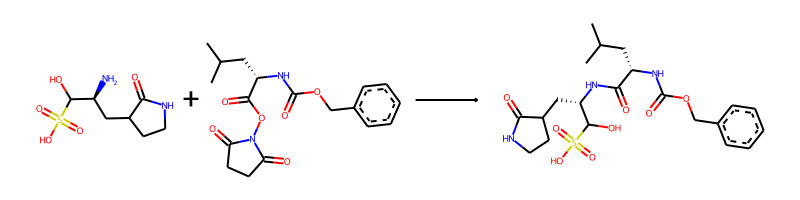

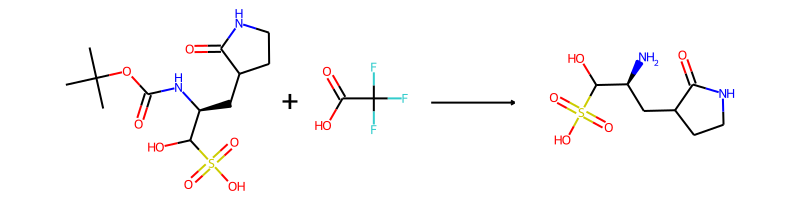

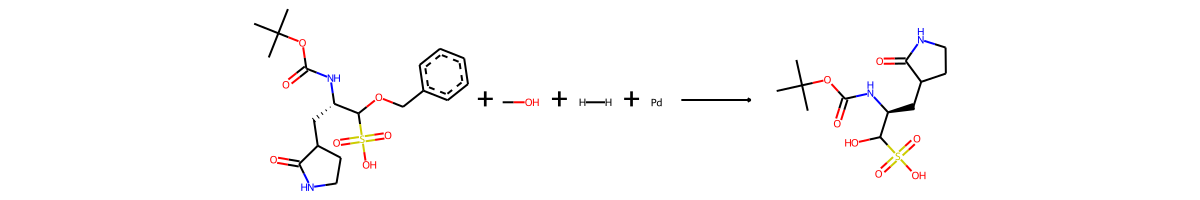

Showing path 1 with confidence 0.614:


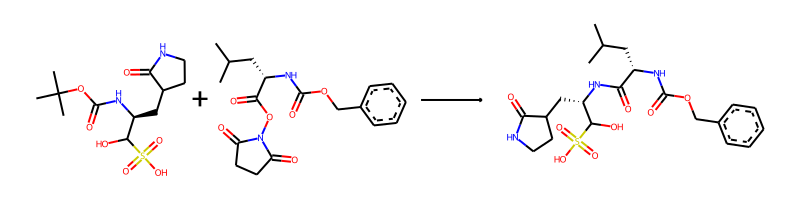

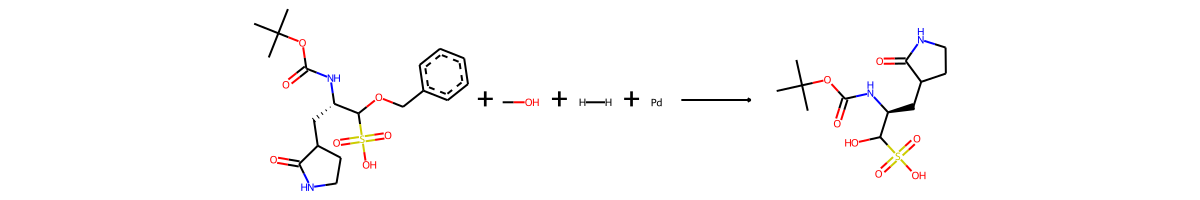

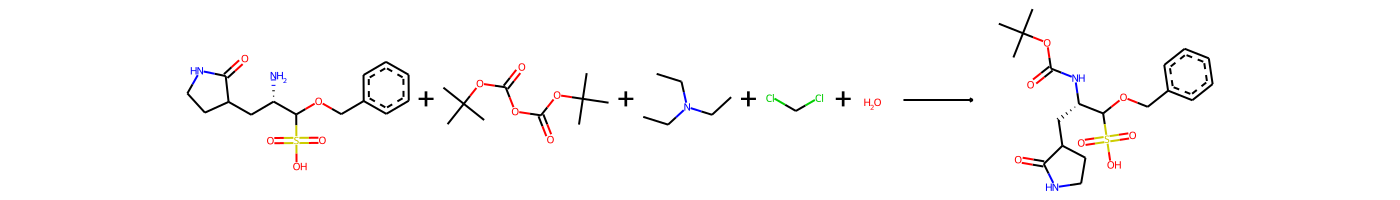

In [44]:
from rdkit import Chem
from rdkit.Chem import AllChem
from IPython.display import display

def collect_actions(tree):
    actions = []
    if 'children' in tree and len(tree['children']):
        actions.append(tree['actions'])

    for node in tree['children']:
        actions.extend(collect_actions(node))
    return actions


def collect_products(tree):
    products = []
    if 'children' in tree and len(tree['children']):
        products.append(tree['smiles'])

    for node in tree['children']:
        products.extend(collect_products(node))
    return products


def collect_rclass(tree):
    rclass = []
    if 'children' in tree and len(tree['children']):
        rclass.append(tree['rclass'])

    for node in tree['children']:
        rclass.extend(collect_rclass(node))
    return rclass

def collect_reactions(tree):
    reactions = []
    if 'children' in tree and len(tree['children']):
        reactions.append(
            AllChem.ReactionFromSmarts('{}>>{}'.format(
                '.'.join([node['smiles'] for node in tree['children']]),
                tree['smiles']
            ), useSmiles=True)
        )

    for node in tree['children']:
        reactions.extend(collect_reactions(node))
    return reactions




for index, path in enumerate(results['retrosynthetic_paths']):
    print('Showing path {} with confidence {}:'.format(index, path['confidence']))
    for reaction in collect_reactions(path):
        display(Chem.Draw.ReactionToImage(reaction))

In [95]:
test_pathway = results["retrosynthetic_paths"][0]

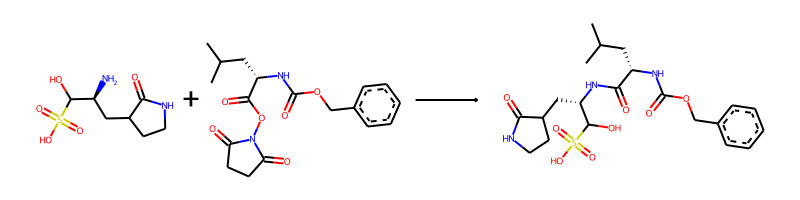

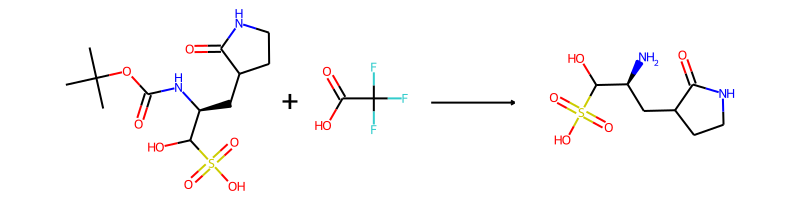

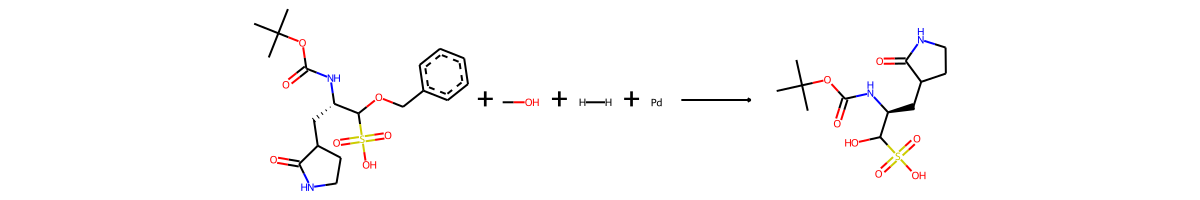

In [46]:
for reaction in collect_reactions(test_pathway):
    display(Chem.Draw.ReactionToImage(reaction))

In [112]:
for rclass in collect_rclass(test_pathway):
    print(rclass)

Unrecognized
N-Boc deprotection
O-Bn deprotection


In [113]:
for product in collect_products(test_pathway):
    print(product)

CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O
N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O
CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O


In [109]:
test_pathway

{'id': '6023f9c8329a1000012530c5',
 'metadata': {},
 'embed': {},
 'computedFields': {},
 'createdOn': 1612970440316,
 'createdBy': 'system',
 'modifiedOn': 1612970440316,
 'modifiedBy': 'system',
 'moleculeId': '5fb6caaba965f9000133514c',
 'retrosynthesisId': '6023f9bc329a1000012530af',
 'sequenceId': '6023f9c8329a1000012530bc',
 'projectId': '6023f99c329a100001253082',
 'smiles': 'CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O',
 'confidence': 0.99,
 'confidenceTag': None,
 'rclass': 'Unrecognized',
 'hasFeedback': False,
 'feedback': None,
 'children': [{'id': '6023f9c8329a1000012530c3',
   'metadata': {},
   'embed': {},
   'computedFields': {},
   'createdOn': 1612970440300,
   'createdBy': 'system',
   'modifiedOn': 1612970440300,
   'modifiedBy': 'system',
   'moleculeId': '5fb6caaba965f9000133514d',
   'retrosynthesisId': '6023f9bc329a1000012530af',
   'sequenceId': '6023f9c8329a1000012530bc',
   'projectId': '6023f99c329a100001253082',
   'smiles': 'N[C@@H

In [55]:
response = rxn4chemistry_wrapper.create_synthesis_from_sequence(sequence_id=results['retrosynthetic_paths'][0]['sequenceId'])
print(response['synthesis_id'])
synthesis_tree, ordered_tree_nodes, ordered_list_of_actions = rxn4chemistry_wrapper.get_synthesis_plan(synthesis_id=response['synthesis_id'])

6023eec4329a100001251dc5


In [69]:
synthesis_tree

{'id': '6023eec6329a100001251dcd',
 'smiles': 'CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O',
 'children': [{'id': '6023eec6329a100001251dce',
   'smiles': 'N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O',
   'children': [{'id': '6023eec6329a100001251dcf',
     'smiles': 'CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O',
     'children': [{'id': '6023eec6329a100001251dd0',
       'smiles': 'CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(OCc1ccccc1)S(=O)(=O)O',
       'children': [],
       'actions': []},
      {'id': '6023eec6329a100001251dd1',
       'smiles': 'CO',
       'children': [],
       'actions': []},
      {'id': '6023eec6329a100001251dd2',
       'smiles': '[H][H]',
       'children': [],
       'actions': []},
      {'id': '6023eec6329a100001251dd3',
       'smiles': '[Pd]',
       'children': [],
       'actions': []}],
     'actions': [{'name': 'add',
       'content': {'atmosphere': None,
        'duration': None,
        'temperature': None,
        'dropwise': {'value

In [65]:
def collect_actions(tree):
    actions = []
    if 'children' in tree and len(tree['children']):
        actions.append(tree['actions'])

    for node in tree['children']:
        actions.extend(collect_actions(node))
    return actions

In [71]:
for actions in collect_actions(synthesis_tree):
    print(actions)

[{'name': 'add', 'content': {'atmosphere': None, 'duration': None, 'temperature': None, 'dropwise': {'value': False, 'quantity': None, 'unit': None}, 'material': {'value': 'N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O', 'quantity': {'value': 5.0, 'unit': 'ml'}, 'unit': None}}, 'status': 'NEW', 'hasSpectrometerPdf': False, 'remainingTime': 0, 'completionPercentage': 0.0, 'expectedTime': 0}, {'name': 'add', 'content': {'atmosphere': None, 'duration': None, 'temperature': None, 'dropwise': {'value': False, 'quantity': None, 'unit': None}, 'material': {'value': 'Z-Leu-OSu', 'quantity': {'value': 1.0, 'unit': 'mmol'}, 'unit': None}}, 'status': 'NEW', 'hasSpectrometerPdf': False, 'remainingTime': 0, 'completionPercentage': 0.0, 'expectedTime': 0}, {'name': 'stir', 'content': {'atmosphere': None, 'duration': {'value': 3600.0, 'quantity': None, 'unit': 'seconds'}, 'temperature': {'value': 25, 'quantity': None, 'unit': 'celsius'}, 'stirring_speed': {'value': 'normal', 'quantity': None, 'unit': None}}, 'st

In [72]:
actions = collect_actions(synthesis_tree)

In [80]:
action_1 = actions[0]

In [84]:
for action in action_1:
    print(action)

{'name': 'add', 'content': {'atmosphere': None, 'duration': None, 'temperature': None, 'dropwise': {'value': False, 'quantity': None, 'unit': None}, 'material': {'value': 'N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O', 'quantity': {'value': 5.0, 'unit': 'ml'}, 'unit': None}}, 'status': 'NEW', 'hasSpectrometerPdf': False, 'remainingTime': 0, 'completionPercentage': 0.0, 'expectedTime': 0}
{'name': 'add', 'content': {'atmosphere': None, 'duration': None, 'temperature': None, 'dropwise': {'value': False, 'quantity': None, 'unit': None}, 'material': {'value': 'Z-Leu-OSu', 'quantity': {'value': 1.0, 'unit': 'mmol'}, 'unit': None}}, 'status': 'NEW', 'hasSpectrometerPdf': False, 'remainingTime': 0, 'completionPercentage': 0.0, 'expectedTime': 0}
{'name': 'stir', 'content': {'atmosphere': None, 'duration': {'value': 3600.0, 'quantity': None, 'unit': 'seconds'}, 'temperature': {'value': 25, 'quantity': None, 'unit': 'celsius'}, 'stirring_speed': {'value': 'normal', 'quantity': None, 'unit': None}}, 'statu

In [117]:
def collect_info(tree):
    rclass = []
    
    if 'children' in tree and len(tree['children']):
#         products.append(tree['smiles'])
        rclass.append(tree['rclass'])
#         reactants.append([node["smiles"] for node in tree["children"]])

    for node in tree['children']:
#         products.extend(collect_info(node))
        rclass.extend(collect_info(node))
#         reactants.extend(collect_info(node))
    
    return rclass

def collect_rclass(tree):
    rclass = []
    if 'children' in tree and len(tree['children']):
        rclass.append(tree['rclass'])

    for node in tree['children']:
        rclass.extend(collect_rclass(node))
    return rclass


rclass = collect_rclass(test_pathway)

In [118]:
rclass

['Unrecognized', 'N-Boc deprotection', 'O-Bn deprotection']

In [64]:
for children in synthesis_tree["children"]:
    print(children)

{'id': '6023eec6329a100001251dce', 'smiles': 'N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O', 'children': [{'id': '6023eec6329a100001251dcf', 'smiles': 'CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O', 'children': [{'id': '6023eec6329a100001251dd0', 'smiles': 'CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(OCc1ccccc1)S(=O)(=O)O', 'children': [], 'actions': []}, {'id': '6023eec6329a100001251dd1', 'smiles': 'CO', 'children': [], 'actions': []}, {'id': '6023eec6329a100001251dd2', 'smiles': '[H][H]', 'children': [], 'actions': []}, {'id': '6023eec6329a100001251dd3', 'smiles': '[Pd]', 'children': [], 'actions': []}], 'actions': [{'name': 'add', 'content': {'atmosphere': None, 'duration': None, 'temperature': None, 'dropwise': {'value': False, 'quantity': None, 'unit': None}, 'material': {'value': 'CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(OCc1ccccc1)S(=O)(=O)O', 'quantity': {'value': 1.0, 'unit': 'mmol'}, 'unit': None}}, 'status': 'NEW', 'hasSpectrometerPdf': False, 'remainingTime': 0, 'completionPercentage': 0.0, 'expe

In [49]:
for action in collect_actions(test_pathway):
    print(action)

KeyError: 'actions'

In [11]:
# Get reaction info about pathway
reaction_info = collectIBMReactionInfo(rxn4chemistry_wrapper=rxn4chemistry_wrapper, pathway=test_pathway)

In [12]:
reaction_info

{'rclass': ['Unrecognized', 'N-Boc deprotection'],
 'product_smiles': ['CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O',
  'N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O'],
 'reactants': [['N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O',
   'CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)ON1C(=O)CCC1=O'],
  ['CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(O)S(=O)(=O)O', 'O=C(O)C(F)(F)F']],
 'actions': [[{'name': 'add',
    'content': {'atmosphere': None,
     'duration': None,
     'temperature': None,
     'dropwise': {'value': False, 'quantity': None, 'unit': None},
     'material': {'value': 'CC(C)(C)OC(=O)N[C@@H](CC1CCNC1=O)C(OCc1ccccc1)S(=O)(=O)O',
      'quantity': {'value': 1.0, 'unit': 'mmol'},
      'unit': None}},
    'status': 'NEW',
    'hasSpectrometerPdf': False,
    'remainingTime': 0,
    'completionPercentage': 0.0,
    'expectedTime': 0},
   {'name': 'add',
    'content': {'atmosphere': None,
     'duration': None,
     'temperature': None,
     'dropwise': {'value': False, 'quantity': None, 'un

In [16]:
response = rxn4chemistry_wrapper.create_synthesis_from_sequence(sequence_id=results["retrosynthetic_paths"][0]['sequenceId'])

Unexpected error.
{"payload":null,"metadata":{"uiMessages":{"errors":[{"code":"DUPLICATED_SYNTHESIS","message":"A synthesis already exists for the selected sequence","type":"ERROR","fieldId":null,"target":"TOAST"}],"infos":[],"warnings":[]},"extendedPagination":{}}}


In [ ]:
# Setup IBM RxN API
api_key=os.environ['IBM_API_KEY'] 
rxn4chemistry_wrapper = RXN4ChemistryWrapper(api_key=api_key)
rxn4chemistry_wrapper.create_project('Test new functions')

In [ ]:
# Each retrosynthetic path predicted has a unique sequence_id that can
# be used to create a new synthesis
response = rxn4chemistry_wrapper.create_synthesis_from_sequence(
    sequence_id=reactions['retrosynthetic_paths'][0]['sequenceId'])
print(response['synthesis_id'])

# get the entire list of actions for the entire synthesis, as well as a tree representation
synthesis_tree, ordered_tree_nodes, ordered_list_of_actions = rxn4chemistry_wrapper.get_synthesis_plan(
    synthesis_id=response['synthesis_id'])
for action in ordered_list_of_actions:
    print(action)

In [ ]:
# Need to convert names to smiles!
# Use the awesome Cactus API - https://cactus.nci.nih.gov/

from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(name):
    try:
        name_converted = quote(name)
        url= 'https://cactus.nci.nih.gov/chemical/structure/' + name_converted + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

identifiers  = ['Z-Leu-OSu']

for ids in identifiers :
    print(ids, CIRconvert(ids))